# Hugging Face and Sagemaker: fine-tuning DistilBERT with tweets_hate_speech_detection

In [36]:
!pip install -qq "sagemaker>=2.48.0" --upgrade
!pip install -qq torch==1.7.1 --upgrade
!pip install -qq sagemaker-huggingface-inference-toolkit 
!pip install -qq transformers==4.6.1 "datasets[s3]"
!pip install -qq ipywidgets
!pip install -qq watermark 
!pip install -qq "seaborn>=0.11.0"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.46 requires botocore==1.23.46, but you have botocore 1.24.0 which is incompatible.
aiobotocore 1.2.2 requires botocore<1.19.53,>=1.19.52, but you have botocore 1.24.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.75.1 requires boto3>=1.20.21, but you have boto3 1.16.43 which is incompatible.
awscli 1.22.46 requires botocore==1.23.46, but you have botocore 1.19.52 which is incompatible.
awscli 1.22.46 requires s3transfer<0.6.0,>=0.5.0, but you have s3transfer 0.3.7 which is incompatible.


# Development environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set up SageMaker session and bucket


In [2]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

In [3]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 17, 8

In [4]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::454124392436:role/service-role/AmazonSageMaker-ExecutionRole-20220201T224378
sagemaker bucket: sagemaker-us-east-2-454124392436
sagemaker session region: us-east-2


# Data preparation
The data preparation is straightforward as you're using the datasets library to download and preprocess the <b> tweets_hate_speech_detection</b> dataset directly from Hugging face. After preprocessing, the dataset will be uploaded to our sagemaker_session_bucket to be used within our training job

In [5]:
dataset_name = 'tweets_hate_speech_detection'
# loading tweet hate speech detection dataset.
dataset = load_dataset(dataset_name)


Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (/home/ec2-user/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/3e953745870454cf8ff15cc48097dbb5ff459596e0a089867c2a29cee63984ec)


In [6]:
print(dataset.column_names)

{'train': ['label', 'tweet']}


In [7]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [8]:
dataset['train']

Dataset({
    features: ['label', 'tweet'],
    num_rows: 31962
})

# DataSet
Total num of records: 31962 <br>
Train: 80% of total records: 25000 <br>
Test: 20% of total records: 6961 <br> 

In [27]:
ds = dataset['train'].shuffle()
train_dataset = ds.select(range(1,20001))


In [28]:
print(train_dataset)

Dataset({
    features: ['label', 'tweet'],
    num_rows: 20000
})


In [29]:
test_dataset = ds.select(range(20001,24001 ))

In [30]:
print(test_dataset)

Dataset({
    features: ['label', 'tweet'],
    num_rows: 4000
})


In [31]:
train_dataset.column_names

['label', 'tweet']

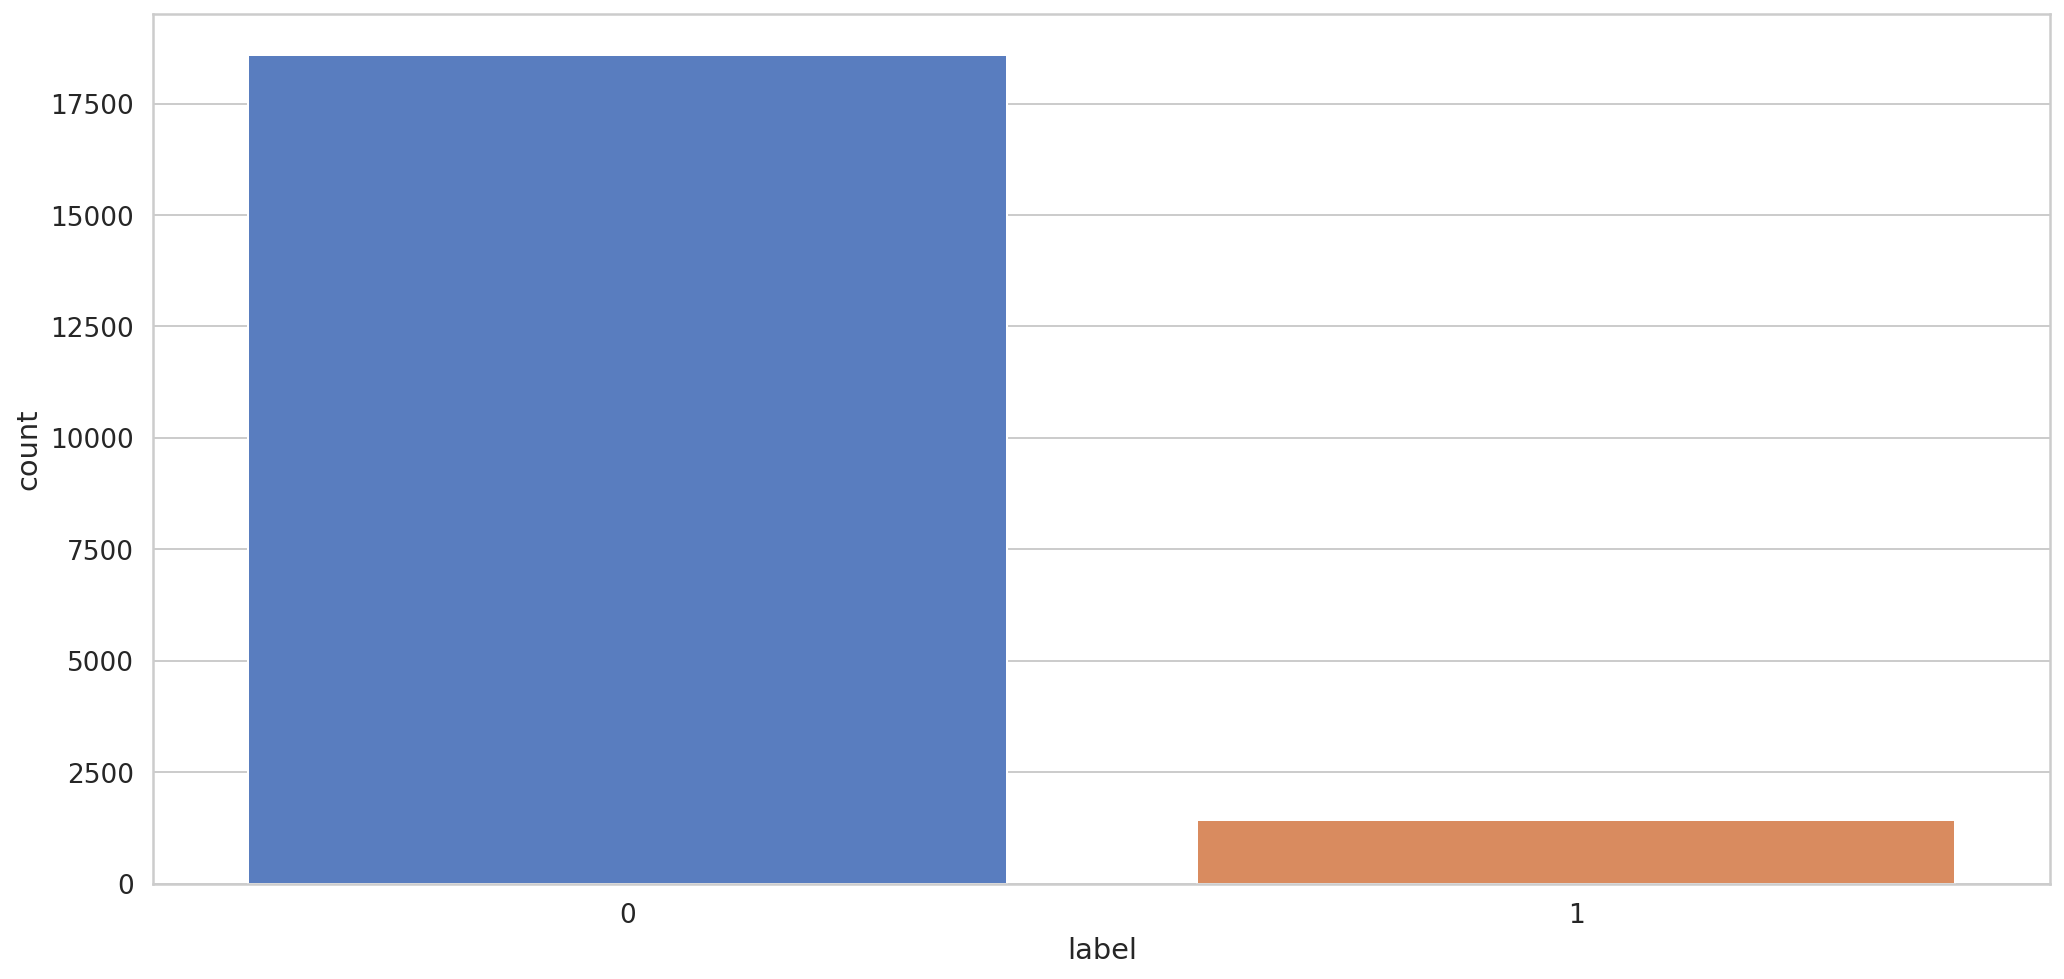

In [32]:
sns.countplot(x=train_dataset['label'])
plt.xlabel('label');

In [33]:
tokenizer_name = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

In [34]:
# Helper function to get the content to tokenize
def tokenize(batch):
    return tokenizer(batch['tweet'], padding='max_length', truncation=True)

# Tokenize

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))
print("Tokenizer completed !")

# Set the format to PyTorch
train_dataset = train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Tokenizer completed !


In [35]:
# print sample record from train_dataset.
print(train_dataset[1])

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0

# Uploading the data to S3

In [36]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
s3 = S3FileSystem()
print("sess.default_bucket()={}".format(sess.default_bucket()))
s3_prefix = f'sagemaker/datasets/{dataset_name}'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)

test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded testing data to {test_input_path}')

sess.default_bucket()=sagemaker-us-east-2-454124392436
Uploaded training data to s3://sagemaker-us-east-2-454124392436/sagemaker/datasets/tweets_hate_speech_detection/train
Uploaded testing data to s3://sagemaker-us-east-2-454124392436/sagemaker/datasets/tweets_hate_speech_detection/test


# Fine-tuning & starting Sagemaker Training Job


In [37]:
!pygmentize ./scripts/train.py

"""
Training script for Hugging Face SageMaker Estimator
"""
import logging
import sys
import argparse
import os
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--tokenizer_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_

# Creating an Estimator and start a training job


In [38]:

model_name ='distilbert-base-cased'
import datetime
ct = datetime.datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name=f'finetune-{model_name}-{current_time}'
print( training_job_name )

finetune-distilbert-base-cased-2022-02-16-17-13-50


In [40]:
hyperparameters={'epochs': 5,
                 'train_batch_size': 32,
                 'model_name': model_name,
                 'tokenizer_name': tokenizer_name,
                 'output_dir':'/opt/ml/checkpoints',
                 }

In [41]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

# Distributed Model training in Spot instance in AWS

In [42]:
# Distributed Training in AWS

# configuration for running training on smdistributed Data Parallel
#distribution = {'smdistributed':{'dataparallel':{ 'enabled': True }}}

use_spot_instances = True
max_run = 36000
max_wait = 36000 if use_spot_instances else None



In [43]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=2,
                            role=role,
                            transformers_version='4.6', 
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters,
                            #use_spot_instances=use_spot_instances,
                            #max_wait=36000,
                            metric_definitions=metric_definitions,
                            max_run=36000, # expected max run in seconds
                        )

In [44]:
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path}, wait=False, job_name=training_job_name )


In [45]:
sess.wait_for_job(training_job_name)



2022-02-16 17:14:13 Starting - Starting the training job.......
2022-02-16 17:14:50 Starting - Preparing the instances for training..........
2022-02-16 17:15:47 Downloading - Downloading input data...
2022-02-16 17:16:08 Training - Downloading the training image.......................................
2022-02-16 17:19:30 Training - Training image download completed. Training in progress..........................................................................................................................................................................................................................................................................................................................................................................................
2022-02-16 17:51:10 Uploading - Uploading generated training model.....................................................................................................................................................................

{'TrainingJobName': 'finetune-distilbert-base-cased-2022-02-16-17-13-50',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:454124392436:training-job/finetune-distilbert-base-cased-2022-02-16-17-13-50',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-2-454124392436/finetune-distilbert-base-cased-2022-02-16-17-13-50/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'epochs': '5',
  'model_name': '"distilbert-base-cased"',
  'output_dir': '"/opt/ml/checkpoints"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"finetune-distilbert-base-cased-2022-02-16-17-13-50"',
  'sagemaker_program': '"train.py"',
  'sagemaker_region': '"us-east-2"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-454124392436/finetune-distilbert-base-cased-2022-02-16-17-13-50/source/sourcedir.tar.gz"',
  'tokenizer_name': '"distilbert-base-cased"',
  'train_batch_size': '32'},
 'AlgorithmSpecification': {'Training

# Training metrics
You can now display the training metrics

In [46]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
df.head(10)

,timestamp,metric_name,value
0,0.0,loss,0.198550
1,300.0,loss,0.096900
2,600.0,loss,0.049100
3,900.0,loss,0.023550
4,1200.0,loss,0.007100
5,1500.0,loss,0.002550
6,0.0,learning_rate,0.000050
7,300.0,learning_rate,4.047619
8,600.0,learning_rate,3.095238
9,900.0,learning_rate,2.142857


<AxesSubplot:label='69706663-988d-42cd-aa12-e037a962fca4', xlabel='timestamp', ylabel='value'>

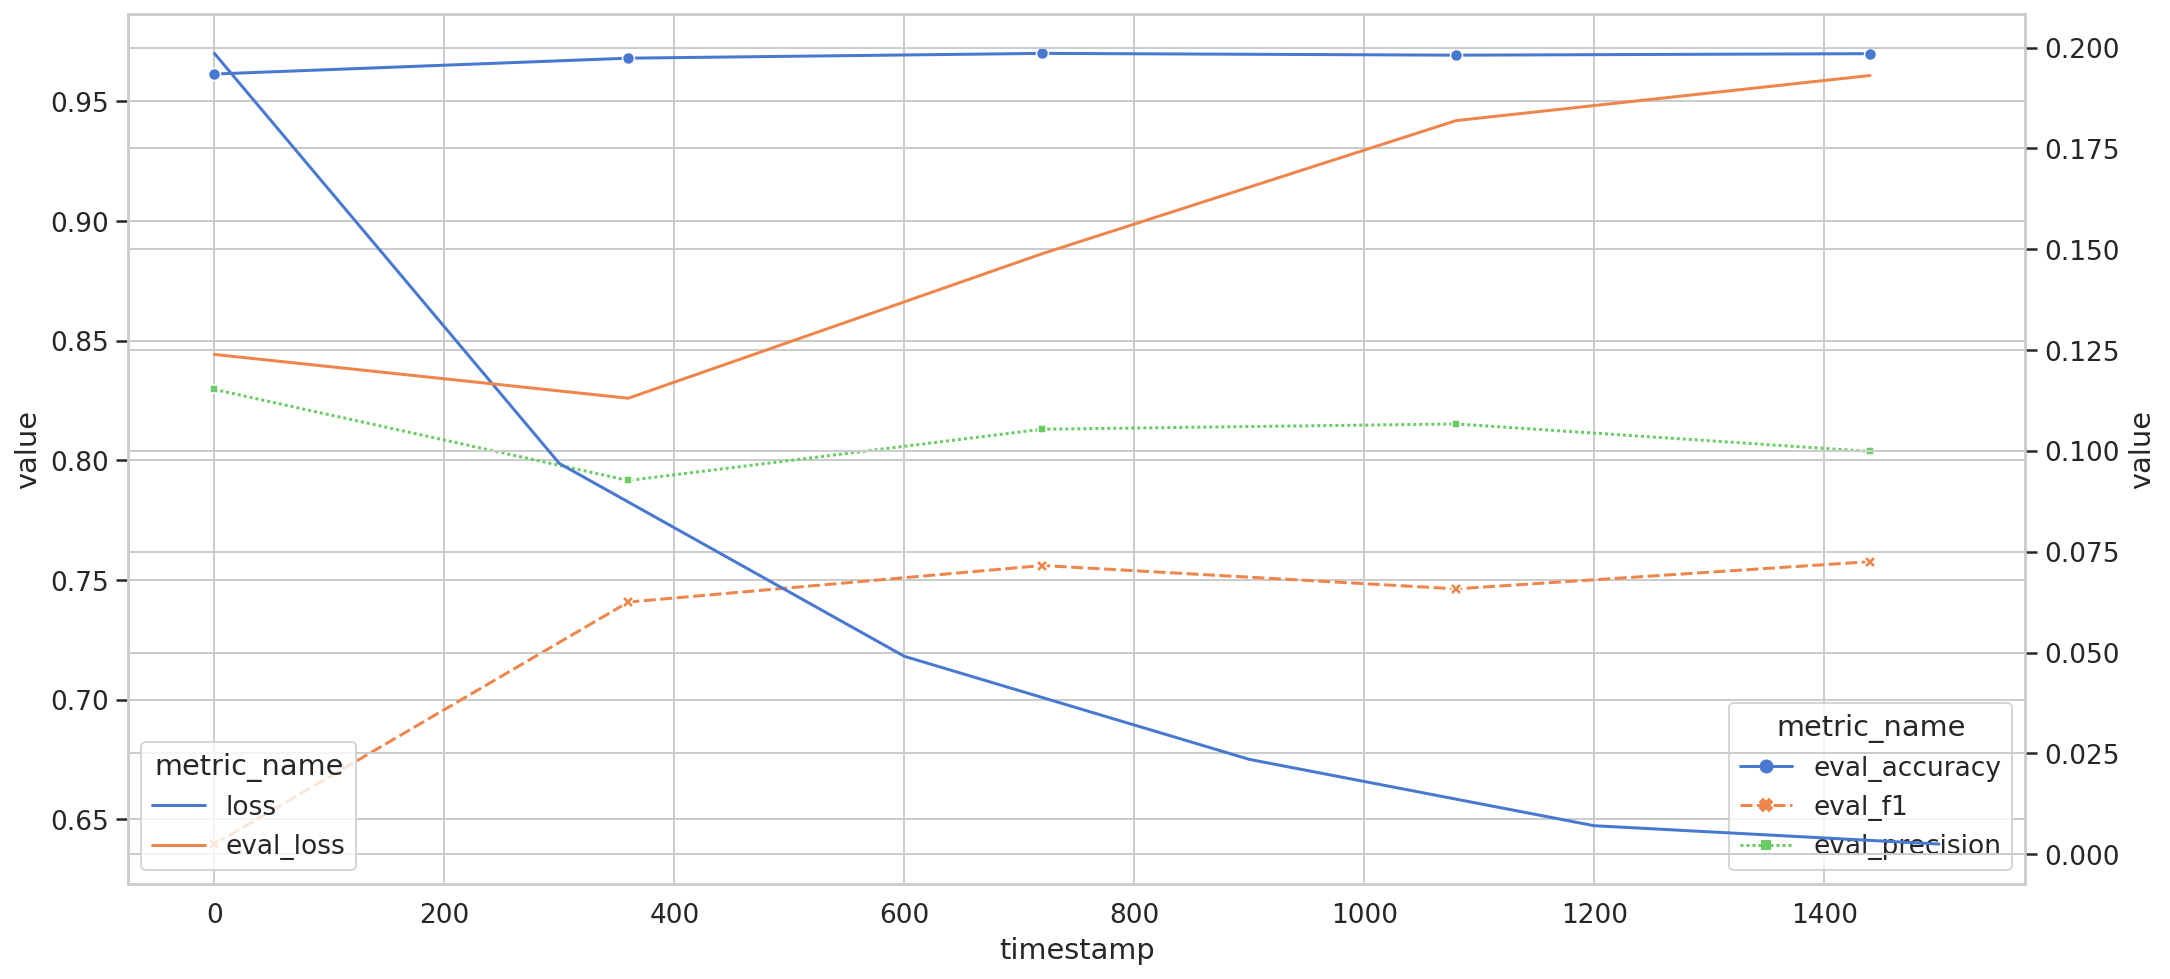

In [47]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision', 'eval_f1'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    style='metric_name',
    markers=True,
    hue='metric_name'
)

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name',
    ax=ax2)

# Endpoint
The transformers pipelines API allows you to use the pipelines features. Your inputs need to be defined in the inputs key. If you want additional supported pipelines parameters you can add them in the parameters key. The API is oriented at the API of the 🤗 Accelerated Inference API, meaning your inputs need to be defined in the inputs key and if you want additional supported pipelines parameters you can add them in the parameters key.

Below are a few request examples:

text-classification request body

{ "inputs": "Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days." } question-answering request body

{ "inputs": { "question": "What is used for inference?", "context": "My Name is Philipp and I live in Nuremberg. This model is used with sagemaker for inference." } } zero-shot classification request body

{ "inputs": "Hi, I recently bought a device from your company but it is not working as advertised and I would like to get reimbursed!", "parameters": { "candidate_labels": [ "refund", "legal", "faq" ] } } You can now proceed and create an endpoint with the trained model.

predictor =

In [48]:
predictor = huggingface_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=training_job_name)


-------!

After the endpoint is deployed you can run a prediction. LABEL_0 indicates a negative review(0 (no-hate-speech)
, LABEL_1 indicates a positive review(1 (hate-speech)
, and score corresponds to the probability of each label.

In [57]:
data = {
   "inputs": [
       "Good product!",
       "Product is not good at all",
       "Idea is good, but product quality is poor"
   ]
}

# request
predictor.predict(data)

[{'label': 'LABEL_0', 'score': 0.999928891658783},
 {'label': 'LABEL_0', 'score': 0.9999623894691467},
 {'label': 'LABEL_0', 'score': 0.9999582171440125}]

In [59]:
data = {
   "inputs": [
       "it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia", # 1-hate speech
       "â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may #blog #silver #gold #forex", # 0 no-hate
       "we are so selfish. #orlando #standwithorlando #pulseshooting #orlandoshooting #biggerproblems #selfish ", # 0 no-hate,
       "retweet if you agree!", # 1 hate-speech
       "no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins" # 1-hate-speech
   ]
}

# request
predictor.predict(data)

[{'label': 'LABEL_1', 'score': 0.9997469782829285},
 {'label': 'LABEL_0', 'score': 0.9999871850013733},
 {'label': 'LABEL_0', 'score': 0.999983012676239},
 {'label': 'LABEL_1', 'score': 0.9996966123580933},
 {'label': 'LABEL_1', 'score': 0.9997279644012451}]

# Cleanup
After you are finished experimenting with this notebook, run the following cell to delete the predictor.

In [60]:
predictor.delete_endpoint()